2b - Considerando um conjunto de imagens satelitais provenientes do sensor WorldView-2 (resolução de 0.5m e 8 bandas espectrais [1], em arquivos .tif), implemente algum método para segmentação da vegetação presente nas cenas.

In [51]:
import rasterio
import numpy as np
import matplotlib.pyplot as plt
import cv2
from sklearn.linear_model import LinearRegression

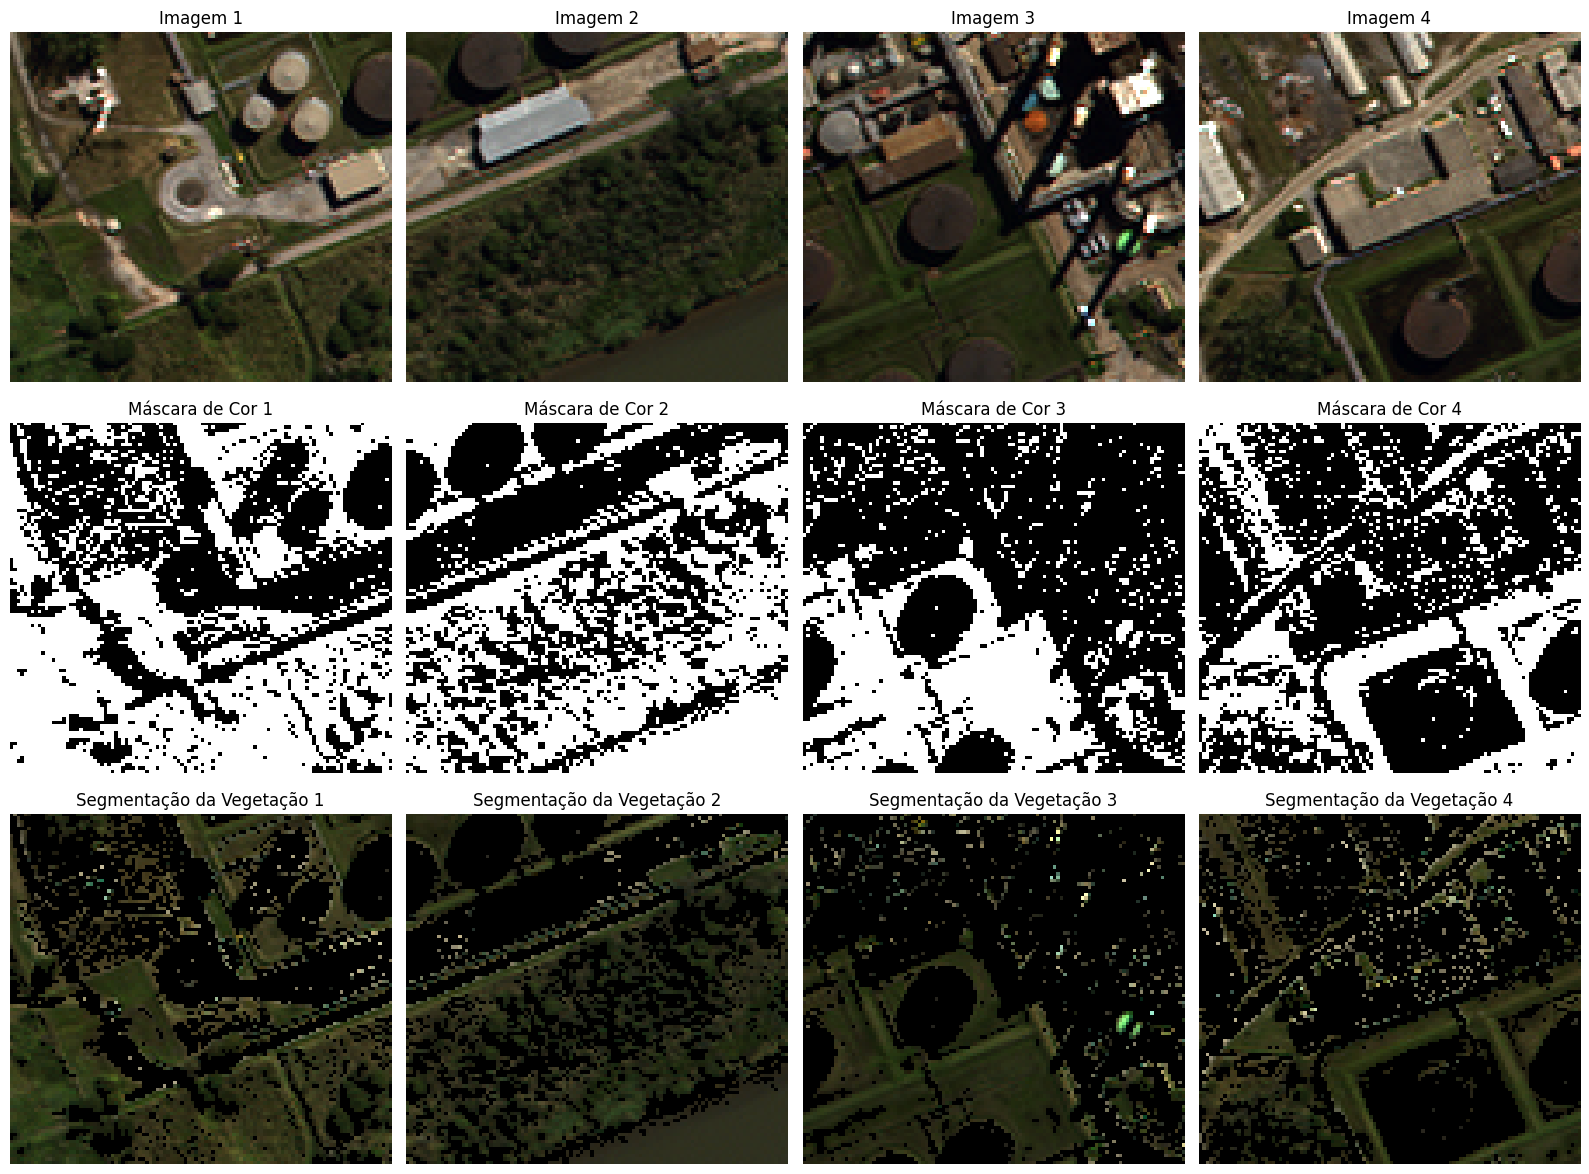

In [142]:
# Atribuir cada imagem RGB a uma variável separada
rgb_image_1, rgb_image_2, rgb_image_3, rgb_image_4 = rgb_images

def segment_color(image):
    # Converter a imagem para o espaço de cores HSV
    hsv_image = cv2.cvtColor((image.transpose(1, 2, 0) * 255).astype(np.uint8), cv2.COLOR_RGB2HSV)
    
    # Definir os intervalos de cor para a vegetação (verde, amarelo e marrom)
    lower_green_1 = np.array([22, 50, 30])  # Limite inferior de matiz, saturação e valor (verde mais escuro)
    upper_green_1 = np.array([45, 255, 255])  # Limite superior de matiz, saturação e valor (verde intermediário)

    lower_green_2 = np.array([46, 50, 30])  # Limite inferior de matiz, saturação e valor (verde intermediário)
    upper_green_2 = np.array([80, 255, 255])  # Limite superior de matiz, saturação e valor (verde mais claro)

    # Criar máscaras de cor para as duas faixas de verde
    mask_1 = cv2.inRange(hsv_image, lower_green_1, upper_green_1)
    mask_2 = cv2.inRange(hsv_image, lower_green_2, upper_green_2)

    # Combinar as máscaras
    mask = cv2.bitwise_or(mask_1, mask_2)
    
    return mask


# Listas para armazenar os resultados
color_masks = []
vegetation_segmenteds = []

# Iterar sobre as imagens e segmentar a cor da vegetação para cada uma
for i, rgb_image in enumerate(rgb_images):
    # Segmentar a cor da vegetação
    color_mask = segment_color(rgb_image)
    color_masks.append(color_mask)
    
    # Segmentar a parte branca (vegetação) da máscara de cor na imagem original
    vegetation_segmented = cv2.bitwise_and(rgb_image.transpose((1, 2, 0)), rgb_image.transpose((1, 2, 0)), mask=color_mask)
    vegetation_segmenteds.append(vegetation_segmented)

# Plotar as imagens originais, as máscaras de cor (vegetação) e as segmentações da vegetação
plt.figure(figsize=(16, 12))

for i in range(len(rgb_images)):
    plt.subplot(3, len(rgb_images), i + 1)
    plt.imshow(rgb_images[i].transpose((1, 2, 0)))
    plt.title(f'Imagem {i+1}')
    plt.axis('off')

    plt.subplot(3, len(rgb_images), len(rgb_images) + i + 1)
    plt.imshow(color_masks[i], cmap='gray')
    plt.title(f'Máscara de Cor {i+1}')
    plt.axis('off')

    plt.subplot(3, len(rgb_images), 2 * len(rgb_images) + i + 1)
    plt.imshow(vegetation_segmenteds[i])
    plt.title(f'Segmentação da Vegetação {i+1}')
    plt.axis('off')

plt.tight_layout()
plt.show()


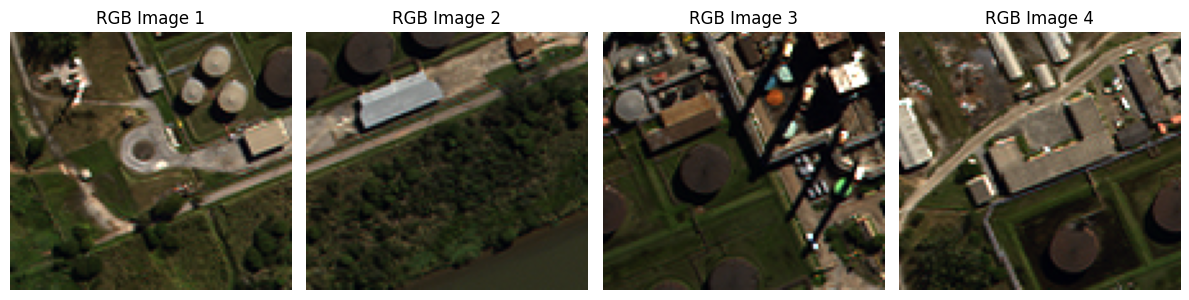

In [ ]:
# Função para ler imagens .tif e retornar como matriz numpy
def read_tif(file_path):
    with rasterio.open(file_path) as src:
        return src.read()

# Lista de caminhos para os arquivos .tif
file_paths = ['../ex2/8band_AOI_1_RIO_img46.tif', '../ex2/8band_AOI_1_RIO_img66.tif', '../ex2/8band_AOI_1_RIO_img67.tif', '../ex2/8band_AOI_1_RIO_img47.tif']

# Ler as imagens .tif e obter metadados
images = [read_tif(file_path) for file_path in file_paths]

# Normalizar os valores dos pixels para o intervalo [0, 1] em cada banda
normalized_images = [(image - np.min(image)) / (np.max(image) - np.min(image)) for image in images]

# Ajustar manualmente o fator de contraste
contrast_factor = 2.5

# Aplicar o fator de contraste ajustado
adjusted_images = [normalized_image * contrast_factor for normalized_image in normalized_images]

# Limitar os valores dos pixels para o intervalo [0, 1]
adjusted_images = [np.clip(image, 0, 1) for image in adjusted_images]

# Supondo que as bandas 4, 3 e 2 correspondam às bandas Red, Green e Blue, respectivamente
rgb_images = [adjusted_image[[3, 2, 1], :, :] for adjusted_image in adjusted_images]

# Plotar as imagens RGB
plt.figure(figsize=(12, 6))
for i, rgb_image in enumerate(rgb_images):
    plt.subplot(1, len(rgb_images), i + 1)
    plt.imshow(rgb_image.transpose((1, 2, 0)))
    plt.title(f'RGB Image {i+1}')
    plt.axis('off')

plt.tight_layout()
plt.show()

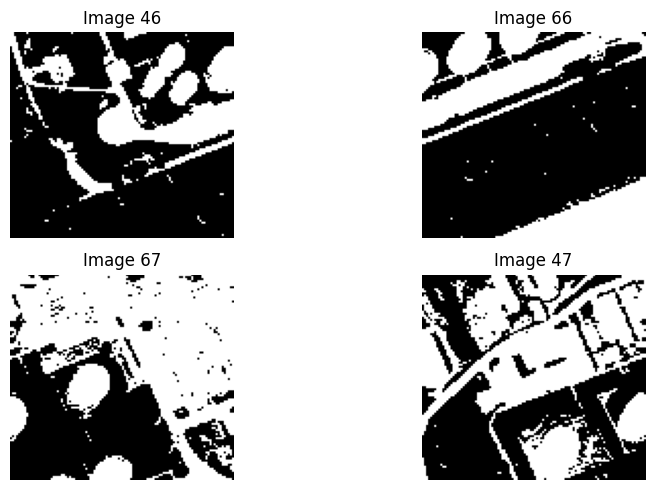

In [183]:
import rasterio
import numpy as np
import matplotlib.pyplot as plt
from skimage.filters import threshold_otsu

def calculate_ndvi(red_band, nir_band):
    # Convertendo para float para evitar problemas de divisão por zero
    red_array = red_band.astype(np.float32)
    nir_array = nir_band.astype(np.float32)
    
    # Calculando o NDVI
    ndvi = (nir_array - red_array) / (nir_array + red_array)
    
    return ndvi

def segment_vegetation(ndvi, threshold):
    # Aplicando o limiar para segmentar a vegetação
    vegetation_mask = np.where(ndvi > threshold, 1, 0)
    return vegetation_mask

def plot_vegetation_segmentation(vegetation_mask, ax, title):
    ax.imshow(vegetation_mask, cmap='binary')
    ax.set_title(title)
    ax.axis('off')

def main():

    file_paths = ['../ex2/8band_AOI_1_RIO_img46.tif', '../ex2/8band_AOI_1_RIO_img66.tif', '../ex2/8band_AOI_1_RIO_img67.tif', '../ex2/8band_AOI_1_RIO_img47.tif']
    
    # Limiar inicial para segmentar a vegetação
    initial_threshold = 0.7
    
    # Criar uma figura com subplots 2x2
    fig, axes = plt.subplots(2, 2, figsize=(10, 5))
    
    # Iterar sobre os caminhos dos arquivos .tif e os subplots correspondentes
    for img_path, ax in zip(file_paths, axes.flatten()):

        with rasterio.open(img_path) as src:
            # Obter as bandas presentes na imagem
            bands = src.indexes
            
            # Selecionar as duas bandas necessárias (RED e NIR) de acordo com WorldView2
            red_band = src.read(bands.index(5))
            nir_band = src.read(bands.index(7))
            
            # Calcular o NDVI
            ndvi = calculate_ndvi(red_band, nir_band)
            
            # Calcular o limiar de Otsu para segmentar a vegetação
            threshold = initial_threshold * threshold_otsu(ndvi)
            
            # Segmentar a vegetação com base no NDVI e no limiar ajustado
            vegetation_mask = segment_vegetation(ndvi, threshold)
            
            # Plotar a área segmentada no subplot correspondente
            plot_vegetation_segmentation(vegetation_mask, ax, f'Image {img_path[-6:-4]}')
    
    plt.tight_layout()
    plt.show()

if __name__ == "__main__":
    main()
